# Unsupervised Analysis: Comprehensive Study of Urban Morphology and Environment

This notebook provides a deep dive into the unsupervised learning analysis of the Geneva dataset. We explore the structural relationships between Environmental Quality (EQ) and Urban Morphology using a suite of advanced techniques.

**Objectives**
1.  **Dimensionality Reduction**: Understand the complexity of our data using PCA.
2.  **Latent Correlation**: Quantify the link between environment and form using CCA and interpret the drivers.
3.  **Clustering**: Identify distinct typologies of neighborhoods. **Note**: Given the small dataset size, we prioritize Hierarchical Clustering over density-based methods.
4.  **Manifold Visualization**: Visualize the high-dimensional landscape.
5.  **Surrogate Validation**: Test if environmental features can predict morphological structure, interpreted via **SHAP**.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.cluster import AgglomerativeClustering

# Add project root to path
current_dir = Path.cwd()
if str(current_dir.parent) not in sys.path:
    sys.path.append(str(current_dir.parent))

# Imports from the unsupervised module
from src.unsupervised.data_loader import load_and_split_data
from src.unsupervised.unsupervised import UnsupervisedAnalyzer
from src.unsupervised.surrogate import SurrogateModel

%matplotlib inline
sns.set_theme(style="whitegrid")

/home/mpello/.conda/envs/mlenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Loading and Preprocessing

We load the integrated data and split it into two views:
- **X (Environment)**: Noise, Pollution, Solar, etc.
- **Y (Morphology)**: Density, Heights, Road Networks, etc.
- **Meta**: Typology labels and pre-computed PCs.

The data is standardized (mean=0, std=1) to ensure fair comparison in distance-based algorithms.

In [2]:
data_path = current_dir.parent / "data" / "morphology_data_integrated.csv"
X, Y, meta = load_and_split_data(data_path)

print(f"Loaded {X.shape[0]} samples.")
print(f"Environmental Features ({X.shape[1]}): {X.columns.tolist()}")
print(f"Morphological Features ({Y.shape[1]}): {Y.columns.tolist()}")

Loaded 240 samples.
Environmental Features (8): ['lst_mean', 'solar_summ', 'solar_wint', 'pm10_mean', 'pm25_mean', 'no2_mean', 'noiseday_m', 'noisenight']
Morphological Features (13): ['building_height', 'height_varability', 'sky_view_factor', 'frontal_area_index', 'water_cover_fraction', 'impervious_surface_cover_fraction', 'building_cover_fraction', 'pervious_surface_cover_fraction', 'aspect_ratio', 'intersections', 'length_primary_road', 'length_secondary_road', 'length_railway']


## 2. Principal Component Analysis (PCA)

Quick check of the explained variance to understand dimensionality.

PCA on Environment (X):
PCA: 4 components explain 95.52% of variance.


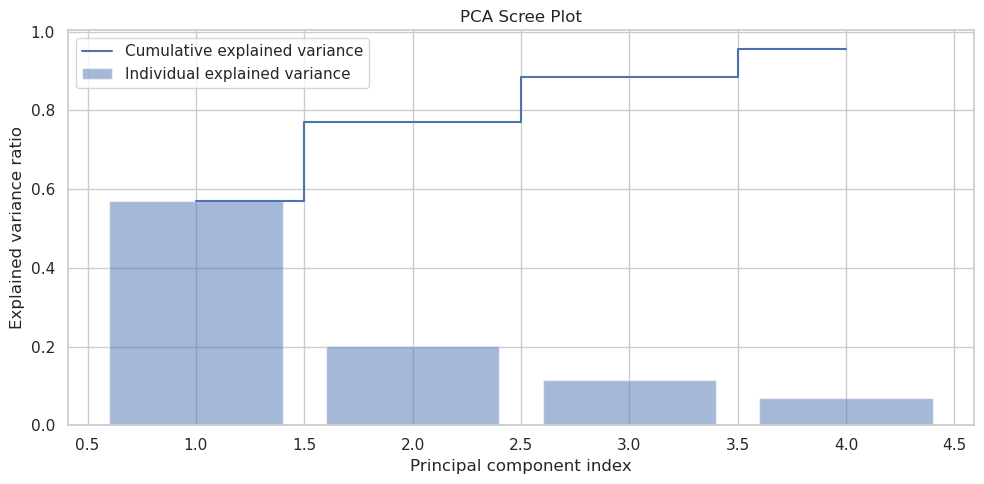

PCA on Morphology (Y):
PCA: 7 components explain 96.17% of variance.


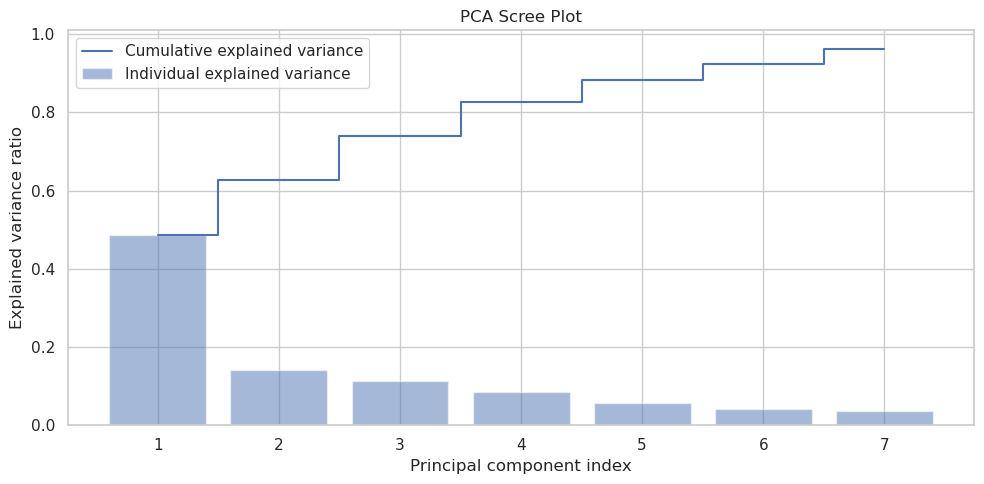

In [3]:
analyzer = UnsupervisedAnalyzer()
print("PCA on Environment (X):")
pca_x, _, _ = analyzer.run_pca(X)
analyzer.plot_pca_start(pca_x)

print("PCA on Morphology (Y):")
pca_y, _, _ = analyzer.run_pca(Y)
analyzer.plot_pca_start(pca_y)

## 3. Canonical Correlation Analysis (CCA)

CCA finds linear combinations of X and Y that are maximally correlated. This helps us understand if there's a strong shared structure between the two domains.

CCA Correlations (Top 2 components): [np.float64(0.6444294443099311), np.float64(0.40507657075377296)]


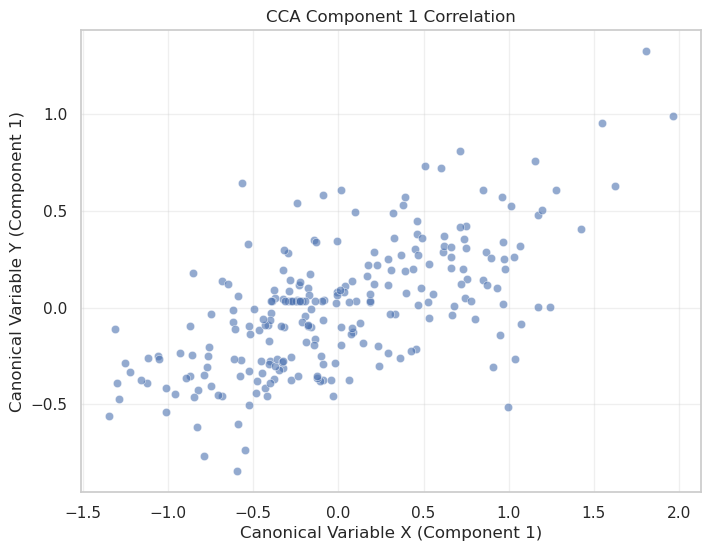

In [4]:
cca, X_c, Y_c = analyzer.run_cca(X, Y, n_components=2)
analyzer.plot_cca_results(X_c, Y_c, component_idx=0)

### Interpretation of CCA Loadings
Which features drive this correlation? The loadings show the correlation between the original features and the Canonical Variates.

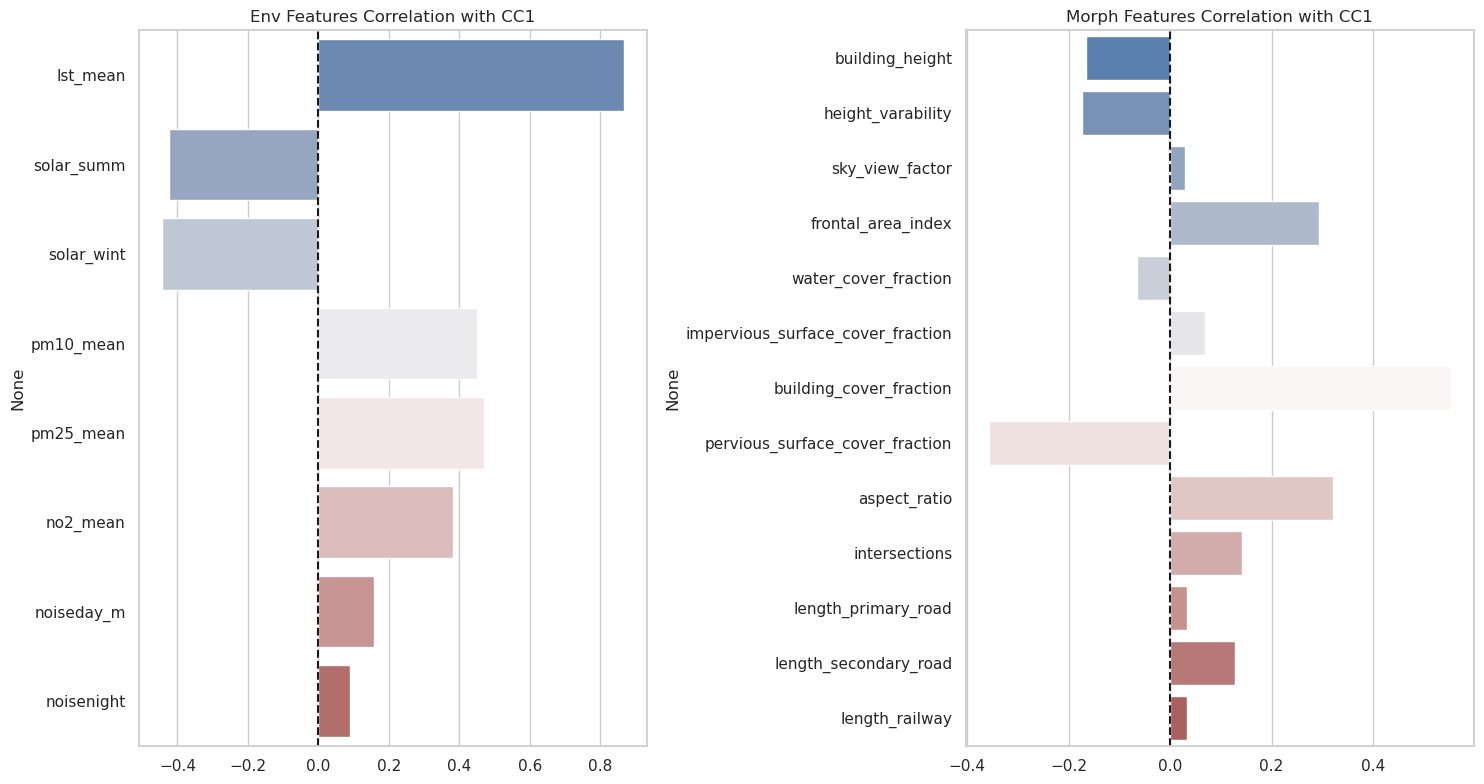

In [5]:
analyzer.plot_cca_loadings(X, Y, cca, component=0)

## 4. Clustering Analysis

Given the limited number of samples, **Hierarchical Clustering** is often more robust than density-based methods (like DBSCAN) as it doesn't rely on local density thresholds. We inspect the Dendrogram to determine the natural number of clusters.

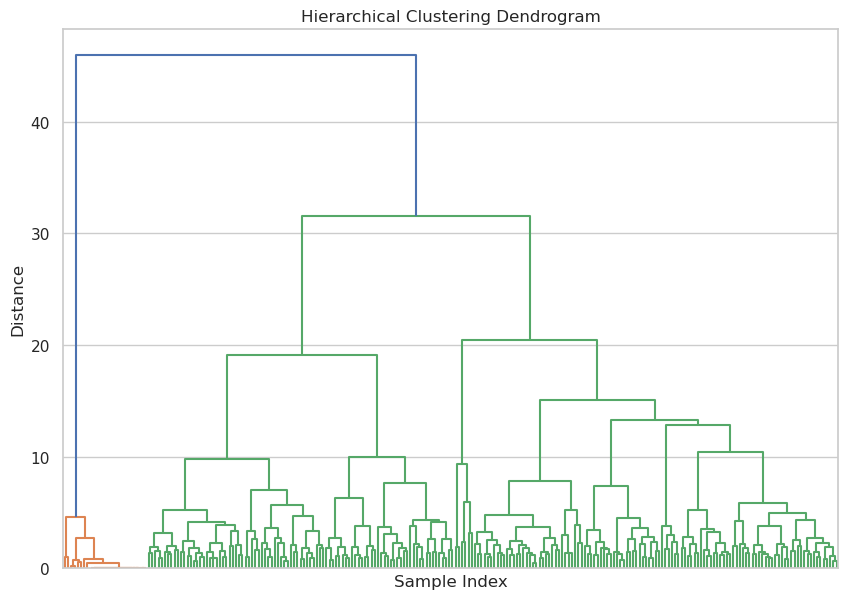

In [6]:
# 1. Hierarchical Clustering Dendrogram
analyzer.run_hierarchical_clustering(Y, method="ward")

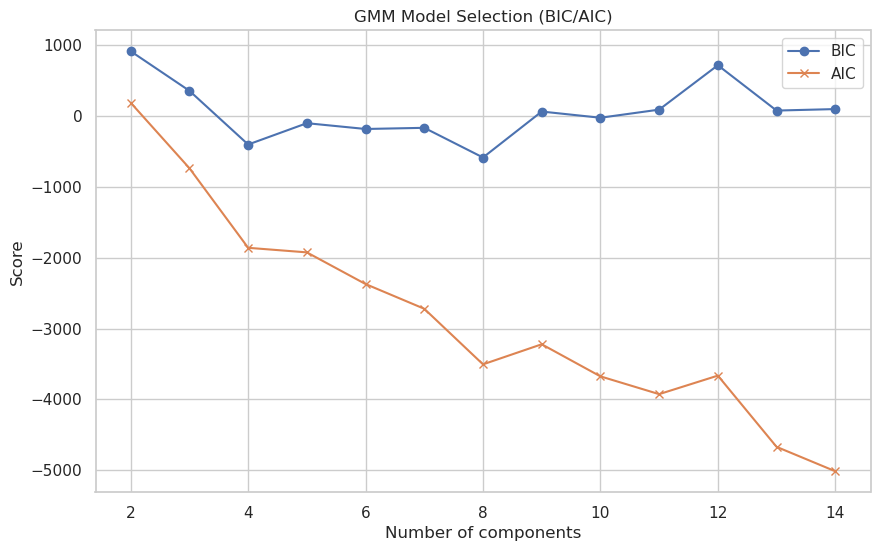

In [7]:
# 2. Model Selection Guidance (GMM BIC/AIC)
# This helps confirm if the number of clusters suggested by the dendrogram is statistically sound.
_ = analyzer.run_gmm(Y, n_components_range=range(2, 15))

In [8]:
# 3. Apply Agglomerative Clustering
# Based on Dendrogram and GMM, we choose a reasonable k (e.g., 3 or 4).
k_clusters = 8  # Adjust this based on the Dendrogram visual
print(f"Applying Agglomerative Clustering with k={k_clusters}...")

hc = AgglomerativeClustering(n_clusters=k_clusters)
labels_morph = hc.fit_predict(Y)

analyzer.evaluate_clustering(Y, labels_morph)

Applying Agglomerative Clustering with k=8...
Clustering Evaluation (n=8):
  Silhouette Score: 0.2542
  Calinski-Harabasz Score: 83.0290


{'silhouette': np.float64(0.2542001864946403),
 'calinski': np.float64(83.02900971381177)}

### Cluster Profiling
Values shown are Z-scores (deviations from the mean).

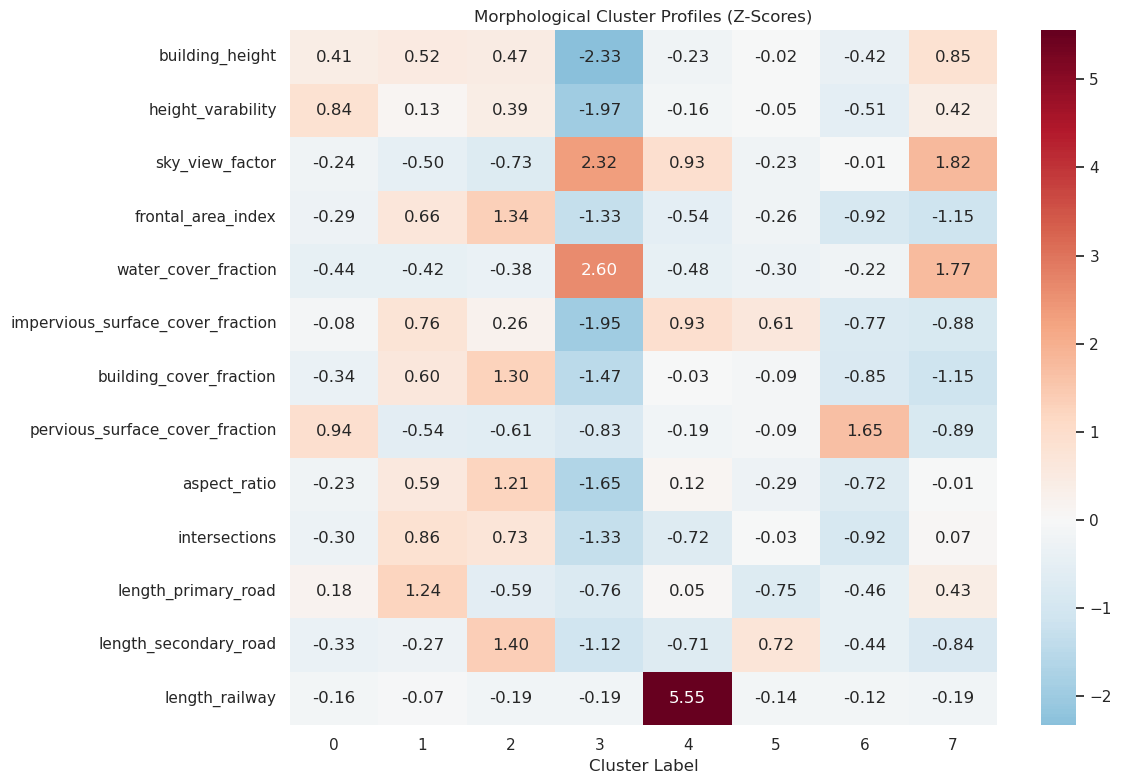

In [9]:
analyzer.plot_cluster_profile(
    Y, labels_morph, title="Morphological Cluster Profiles (Z-Scores)"
)

## 5. Manifold Learning
Visualizing the high-dimensional morphology space in 2D, colored by our new clusters.

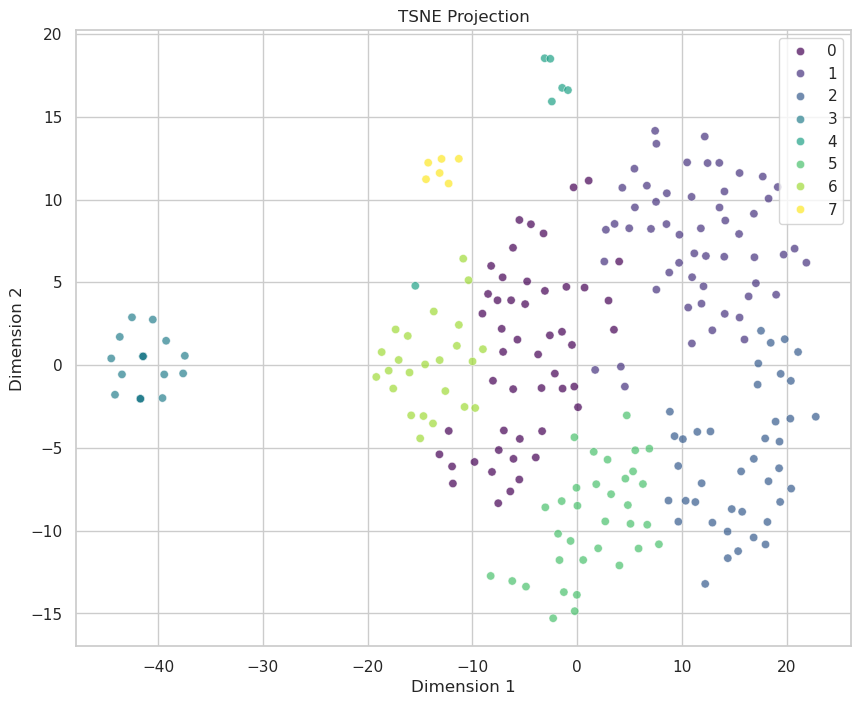

In [10]:
analyzer.run_manifold_learning(Y, color_by=labels_morph, method="tsne")

## 6. Surrogate Learning: Env -> Morph

**Objective**: Can environmental quality predict the morphological structure? 
We use **SHAP (SHapley Additive exPlanations)** to interpret the models.

--- I. Regression: Predicting Morphological Features directly ---
Surrogate Model (Ridge) Performance:
  Avg R2: -0.0728
  RMSE: 1.0444

[Regression SHAP] Understanding environmental drivers for morphology:
Running SHAP analysis on the first target dimension...


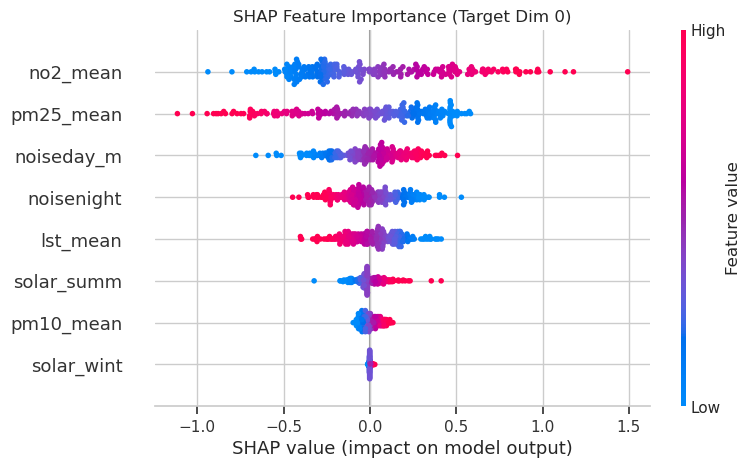

In [11]:
print("--- I. Regression: Predicting Morphological Features directly ---")
surrogate = SurrogateModel(model_type="ridge")
surrogate.train(X, Y)

# SHAP Analysis for Regression
print("\n[Regression SHAP] Understanding environmental drivers for morphology:")
surrogate.analyze_feature_importance(X)


Classification Report (Env -> Morph Cluster):
              precision    recall  f1-score   support

           0       0.40      0.59      0.48        49
           1       0.25      0.24      0.25        55
           2       0.26      0.33      0.29        40
           3       0.52      0.46      0.49        26
           4       0.00      0.00      0.00         6
           5       0.16      0.15      0.15        34
           6       0.08      0.04      0.06        24
           7       0.00      0.00      0.00         6

    accuracy                           0.30       240
   macro avg       0.21      0.23      0.21       240
weighted avg       0.27      0.30      0.28       240



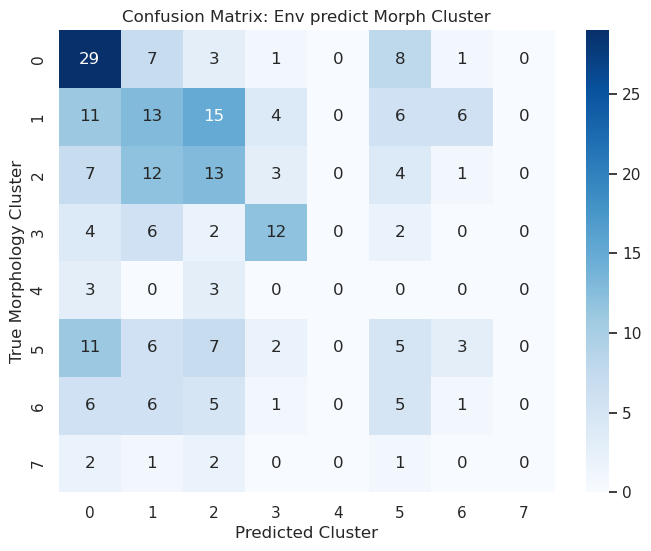

<Figure size 640x480 with 0 Axes>

Running SHAP analysis for Classification...


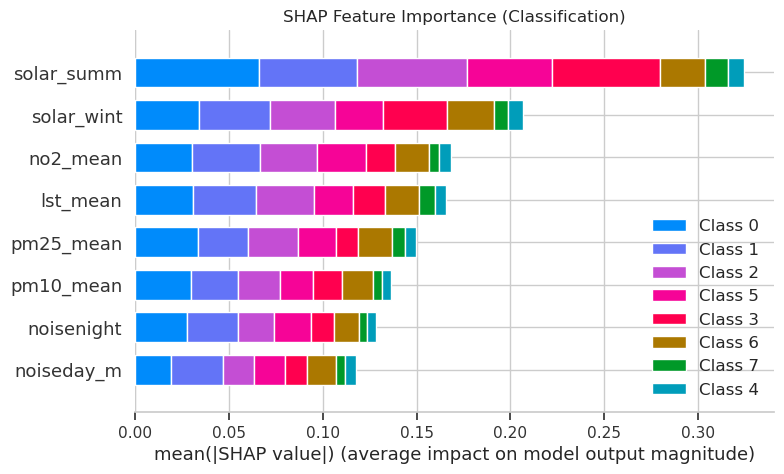

In [12]:
# Evaluate Classification (Env -> Morph Cluster)
# This includes SHAP analysis for the Classifier
surrogate.evaluate_classification(X, labels_morph)

## 7. Improved surrogate experiments

We keep the original surrogate intact and add two lightweight checks:
- Regress PCA-compressed morphology (lower noise, fewer targets) from environment using cross-validated Ridge and Random Forest.
- Classify morphology clusters directly from environment with stronger baselines and cross-validated weighted F1. 

In [13]:
# Regression: predict PCA-compressed morphology from environment (CV R2)
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor

# keeping 90% variance
pca = PCA(n_components=0.90, random_state=42)
Y_pca = pca.fit_transform(Y)
explained = pca.explained_variance_ratio_.sum()

# 5-fold cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
# log space grid search for ridge regression hyperparameter
ridge = RidgeCV(alphas=np.logspace(-3, 3, 9), cv=cv)
# randomforest definition to enhance prexiction capabilities
rf = RandomForestRegressor(n_estimators=400, max_depth=None, random_state=42)

models = {
    "RidgeCV": ridge,
    "RandomForestRegressor": rf,
}

rows = []
for name, model in models.items():
    scores = cross_val_score(model, X, Y_pca, cv=cv, scoring="r2")
    rows.append({"model": name, "mean_R2": scores.mean(), "std_R2": scores.std()})

results_pca = pd.DataFrame(rows).sort_values("mean_R2", ascending=False)
print(f"PCA components retained: {Y_pca.shape[1]} (explained variance={explained:.3f})")
display(results_pca)

PCA components retained: 6 (explained variance=0.924)


,model,mean_R2,std_R2
1,RandomForestRegressor,0.016279,0.111775
0,RidgeCV,-0.020245,0.030982


In [14]:
# Classification: predict morphology clusters from environment (CV weighted F1)
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


mask = labels_morph != -1
X_cls = X[mask]
y_cls = labels_morph[mask]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_weighted = make_scorer(f1_score, average="weighted")

models_cls = {
    "LogReg (L2)": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=5000, class_weight="balanced", multi_class="auto"),
    ),
    "SVM (RBF)": make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf", probability=True, class_weight="balanced", gamma="scale"),
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, max_depth=None, class_weight="balanced", random_state=42
    ),
}

rows = []
for name, model in models_cls.items():
    scores = cross_val_score(model, X_cls, y_cls, cv=skf, scoring=f1_weighted)
    rows.append(
        {"model": name, "mean_F1_weighted": scores.mean(), "std_F1": scores.std()}
    )

results_cls = pd.DataFrame(rows).sort_values("mean_F1_weighted", ascending=False)
display(results_cls)

/home/mpello/.conda/envs/mlenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/mpello/.conda/envs/mlenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/mpello/.conda/envs/mlenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/mpello/.conda/envs/mlenv/lib/python3.12/site-packages/sklearn/linear_model/_log

,model,mean_F1_weighted,std_F1
2,RandomForest,0.304621,0.039090
1,SVM (RBF),0.223542,0.019669
0,LogReg (L2),0.164987,0.042869


Best model: RandomForest | CV weighted F1: 0.308


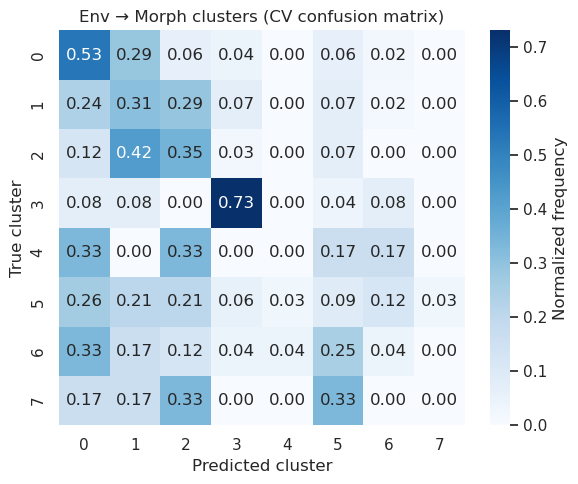

In [15]:
# Visualize morphology-cluster predictions (cross-validated confusion matrix)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score

# Picking the bets performing model we have
best_row = results_cls.iloc[0]
best_name = best_row["model"]
best_model = models_cls[best_name]

# intuitive cluster-level view
y_pred_cv = cross_val_predict(best_model, X_cls, y_cls, cv=skf)

cm = confusion_matrix(y_cls, y_pred_cv, labels=np.unique(y_cls))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

f1_cv = f1_score(y_cls, y_pred_cv, average="weighted")
print(f"Best model: {best_name} | CV weighted F1: {f1_cv:.3f}")

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    ax=ax,
    cbar_kws={"label": "Normalized frequency"},
)
ax.set_xlabel("Predicted cluster")
ax.set_ylabel("True cluster")
ax.set_title("Env → Morph clusters (CV confusion matrix)")
plt.tight_layout()
plt.show()

### 7.4 XGBoost with class-aware oversampling
Try an XGBoost classifier with SMOTE oversampling for rare clusters and a small grid on depth and learning rate. This is done because some clusters were hardly ever predicted

/home/mpello/.conda/envs/mlenv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/mpello/.conda/envs/mlenv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/mpello/.conda/envs/mlenv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/mpello/.conda/envs/mlenv/

,n_estimators,max_depth,learning_rate,min_child_weight,mean_F1_weighted,std_F1
6,300,5,0.05,1,0.311895,0.058198
14,300,7,0.10,1,0.309656,0.055154
4,300,3,0.20,1,0.302410,0.055618
0,300,3,0.05,1,0.299213,0.032670
8,300,5,0.10,1,0.298603,0.056171
12,300,7,0.05,1,0.297098,0.066957
16,300,7,0.20,1,0.292445,0.035322
2,300,3,0.10,1,0.290658,0.048428
7,300,5,0.05,5,0.289218,0.047375
13,300,7,0.05,5,0.289123,0.050453


/home/mpello/.conda/envs/mlenv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/mpello/.conda/envs/mlenv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/mpello/.conda/envs/mlenv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/mpello/.conda/envs/mlenv/

Best XGBoost params: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1} | CV weighted F1: 0.317


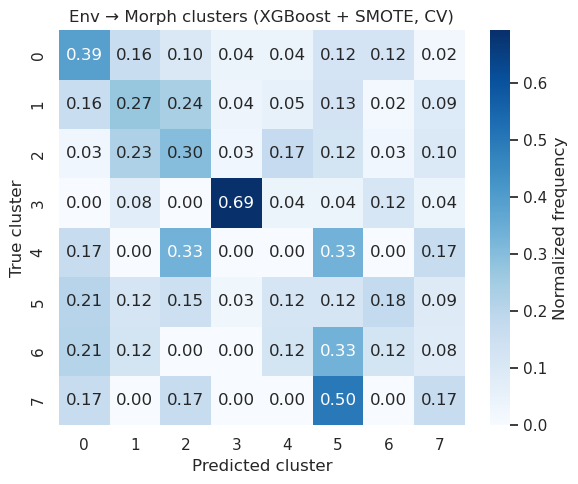

In [16]:
# 7.4 XGBoost with SMOTE oversampling for rare clusters
import numpy as np
import pandas as pd
from itertools import product
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Reuse the balanced subset (exclude noise if any)
mask = labels_morph != -1
X_xgb = X[mask]
y_xgb = labels_morph[mask]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Small, tractable grid for depth and learning rate
param_grid = {
    "n_estimators": [300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1, 0.2],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "min_child_weight": [1, 5],
}

rows = []
best_model = None
best_f1 = -np.inf

param_list = list(
    product(
        param_grid["n_estimators"],
        param_grid["max_depth"],
        param_grid["learning_rate"],
        param_grid["subsample"],
        param_grid["colsample_bytree"],
        param_grid["min_child_weight"],
    )
)

for n_est, depth, lr, subs, cols, mcw in param_list:
    clf = XGBClassifier(
        n_estimators=n_est,
        max_depth=depth,
        learning_rate=lr,
        subsample=subs,
        colsample_bytree=cols,
        min_child_weight=mcw,
        objective="multi:softprob",
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
    )

    pipeline = Pipeline(
        [("smote", SMOTE(k_neighbors=3, random_state=42)), ("clf", clf)]
    )
    scores = cross_val_score(pipeline, X_xgb, y_xgb, cv=skf, scoring="f1_weighted")

    mean_f1 = scores.mean()
    std_f1 = scores.std()
    rows.append(
        {
            "n_estimators": n_est,
            "max_depth": depth,
            "learning_rate": lr,
            "min_child_weight": mcw,
            "mean_F1_weighted": mean_f1,
            "std_F1": std_f1,
        }
    )

    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_params = {
            "n_estimators": n_est,
            "max_depth": depth,
            "learning_rate": lr,
            "subsample": subs,
            "colsample_bytree": cols,
            "min_child_weight": mcw,
        }

# Display grid results
xgb_results = pd.DataFrame(rows).sort_values("mean_F1_weighted", ascending=False)
display(xgb_results)

# Fit best model with SMOTE on full data and show CV confusion matrix
best_clf = XGBClassifier(
    **best_params,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
)
best_pipe = Pipeline(
    [("smote", SMOTE(k_neighbors=3, random_state=42)), ("clf", best_clf)]
)

# Cross-validated predictions for visualization
cv_preds = cross_val_predict(best_pipe, X_xgb, y_xgb, cv=skf)
cv_f1 = f1_score(y_xgb, cv_preds, average="weighted")

cm = confusion_matrix(y_xgb, cv_preds, labels=np.unique(y_xgb))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

print(f"Best XGBoost params: {best_params} | CV weighted F1: {cv_f1:.3f}")

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    ax=ax,
    cbar_kws={"label": "Normalized frequency"},
)
ax.set_xlabel("Predicted cluster")
ax.set_ylabel("True cluster")
ax.set_title("Env → Morph clusters (XGBoost + SMOTE, CV)")
plt.tight_layout()
plt.show()

### 7.5 Diagnostics: per-class scores and feature importances
Summarize per-cluster precision/recall/F1 from cross-val predictions and inspect the top environmental drivers learned by XGBoost (fitted on SMOTE-balanced data).

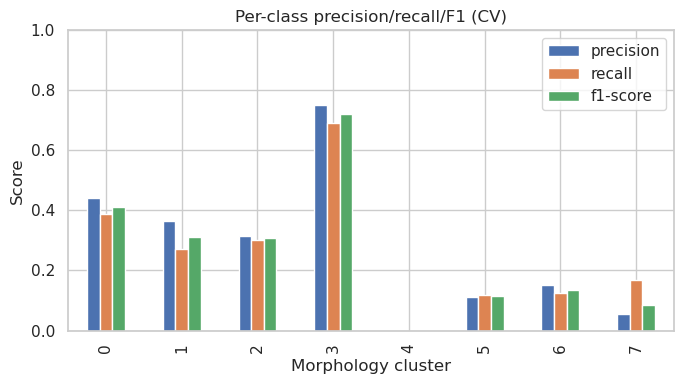

/home/mpello/.conda/envs/mlenv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/tmp/ipykernel_544675/161929811.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, y="feature", x="importance", ax=ax, palette="Blues_r")


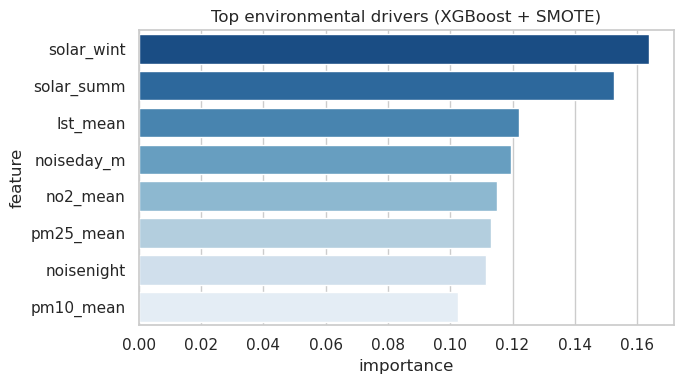

In [17]:
# Per-class metrics and feature importances
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Per-class metrics from existing CV predictions (cv_preds, y_xgb) created above
report = classification_report(y_xgb, cv_preds, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).T


class_rows = report_df.loc[
    [c for c in report_df.index if c not in ["accuracy", "macro avg", "weighted avg"]]
].copy()
class_rows = class_rows[["precision", "recall", "f1-score"]]

fig, ax = plt.subplots(figsize=(7, 4))
class_rows.plot(kind="bar", ax=ax)
ax.set_title("Per-class precision/recall/F1 (CV)")
ax.set_xlabel("Morphology cluster")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

# Fit best XGB on SMOTE-balanced data to inspect feature importances
smote = SMOTE(k_neighbors=3, random_state=42)
X_bal, y_bal = smote.fit_resample(X_xgb, y_xgb)

best_clf_fit = XGBClassifier(
    **best_params,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
)
best_clf_fit.fit(X_bal, y_bal)

importances = best_clf_fit.feature_importances_
fi_df = pd.DataFrame({"feature": X_xgb.columns, "importance": importances})
fi_df = fi_df.sort_values("importance", ascending=False).head(12)

fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(data=fi_df, y="feature", x="importance", ax=ax, palette="Blues_r")
ax.set_title("Top environmental drivers (XGBoost + SMOTE)")
plt.tight_layout()
plt.show()

## 8. Environmental Quality Clustering with GMM

We now cluster the environmental features (X) directly using Gaussian Mixture Models to identify distinct environmental quality typologies. Then we explore whether these EQ-based clusters can predict neighbourhood typology.

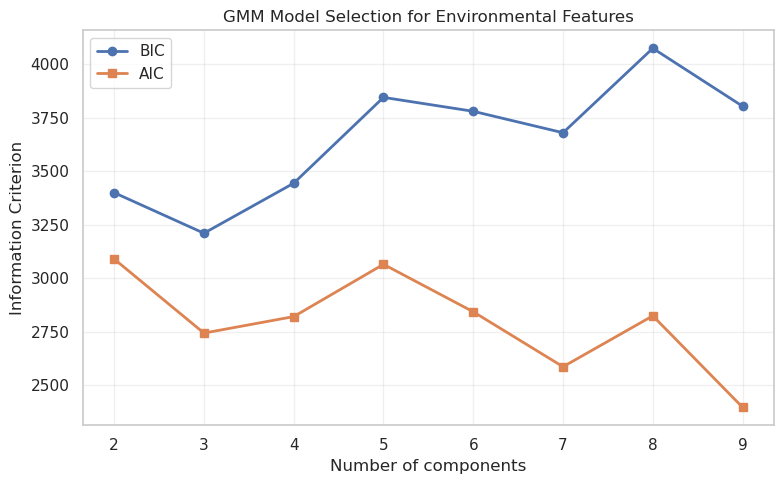

Optimal number of components (BIC): 3
Optimal number of components (AIC): 9


In [18]:
# 8.1 GMM Model Selection for Environmental Features
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Test different numbers of components
n_components_range = range(2, 10)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42, covariance_type="full")
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))
    aic_scores.append(gmm.aic(X))

# Plot model selection criteria
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(n_components_range, bic_scores, "o-", label="BIC", linewidth=2)
ax.plot(n_components_range, aic_scores, "s-", label="AIC", linewidth=2)
ax.set_xlabel("Number of components")
ax.set_ylabel("Information Criterion")
ax.set_title("GMM Model Selection for Environmental Features")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Select optimal number based on lowest BIC
optimal_n = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of components (BIC): {optimal_n}")
print(
    f"Optimal number of components (AIC): {n_components_range[np.argmin(aic_scores)]}"
)

In [19]:
# 8.2 Fit GMM with optimal components and extract cluster labels
k_eq = optimal_n  # Use the optimal number from BIC
print(f"Fitting GMM with {k_eq} components on Environmental Features...")

gmm_eq = GaussianMixture(n_components=k_eq, random_state=42, covariance_type="full")
labels_eq = gmm_eq.fit_predict(X)

# Evaluate clustering quality
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)

sil_score = silhouette_score(X, labels_eq)
db_score = davies_bouldin_score(X, labels_eq)
ch_score = calinski_harabasz_score(X, labels_eq)

print(f"\nClustering Quality Metrics:")
print(f"  Silhouette Score: {sil_score:.3f} (higher is better, range [-1, 1])")
print(f"  Davies-Bouldin Index: {db_score:.3f} (lower is better)")
print(f"  Calinski-Harabasz Index: {ch_score:.1f} (higher is better)")
print(f"\nCluster sizes: {np.bincount(labels_eq)}")

Fitting GMM with 3 components on Environmental Features...

Clustering Quality Metrics:
  Silhouette Score: 0.098 (higher is better, range [-1, 1])
  Davies-Bouldin Index: 2.530 (lower is better)
  Calinski-Harabasz Index: 62.3 (higher is better)

Cluster sizes: [ 48  86 106]


### 8.3 Environmental Cluster Profiling
Characterize each EQ cluster by its mean environmental feature values (in Z-scores).

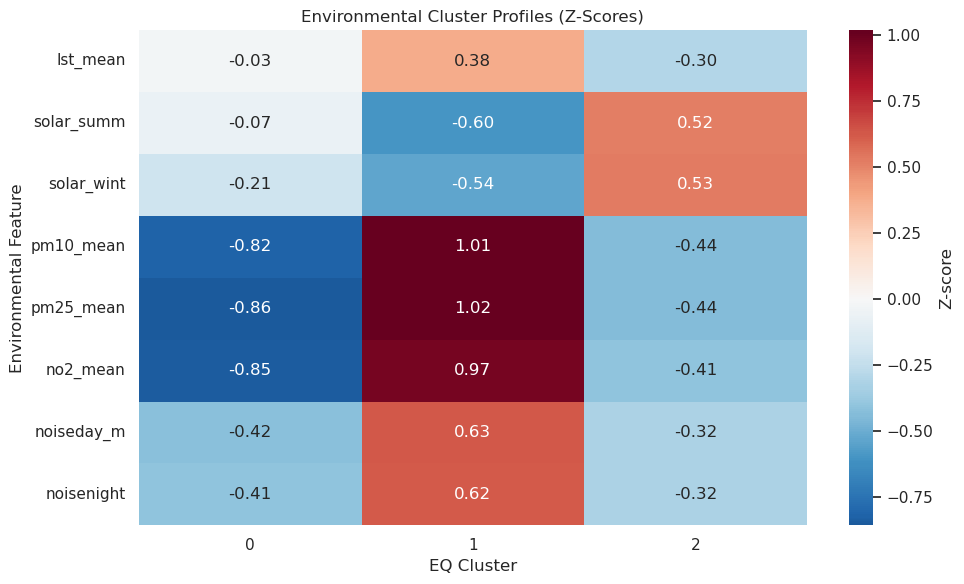


Cluster Distribution:
EQ_Cluster
0     48
1     86
2    106
Name: count, dtype: int64


In [20]:
# Profile EQ clusters by their mean feature values
X_with_labels = X.copy()
X_with_labels["EQ_Cluster"] = labels_eq

# Compute mean Z-scores for each cluster
cluster_profiles = X_with_labels.groupby("EQ_Cluster").mean()

# Visualize cluster profiles as heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    cluster_profiles.T,
    cmap="RdBu_r",
    center=0,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Z-score"},
    ax=ax,
)
ax.set_xlabel("EQ Cluster")
ax.set_ylabel("Environmental Feature")
ax.set_title("Environmental Cluster Profiles (Z-Scores)")
plt.tight_layout()
plt.show()

# Display cluster sizes
print("\nCluster Distribution:")
print(X_with_labels["EQ_Cluster"].value_counts().sort_index())